In [12]:
import numpy as np 
from pathlib import Path
#the line below accesses the file path of the images. Since the main.py file and the archive folder is under the malaria folder, 
#i dont have to write malaria as a part of the file pat
path = Path("archive/cell_images") 
#path.glob gets all the files and folders matching the identifier specified in the argument. it works for with file names,
#and extensions. '*/*.png' includes all subfolders and to not include subfolders its '*.png'
data = list(path.glob('*/*.png'))
uninfected = list(path.glob("Uninfected/*"))
print(len(uninfected))
print(len(data))
print(path.exists())

13780
27558
True


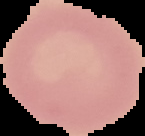

In [13]:
#just wanted to open the images
import PIL
PIL.Image.open(uninfected[1])

In [14]:
#resizing images to standardize the data because it leads to more consistentcy from the model
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
#defines transformer and resizes images 
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
#loads dataset
dataset = datasets.ImageFolder(root='archive/cell_images', transform=transform)

#split the data into training, validating, and test. validating is used so we can see how the model looks while its training on it itself
#test is used so we can just test the model without seeing whats going on 
train_size = int(0.8 * len(dataset)) #training data is 80% of the dataset
val_size = len(dataset) - train_size #validating data is 20% of the dataset

#randomly splits the data
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [15]:
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),  #half blurred
    transforms.ToTensor(),
])
val_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),  
])

train_dataset.dataset.transform = train_transforms
val_dataset.dataset.transform = val_transforms

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
import torch.nn as nn
import torch.nn.functional as func

class NeuralNet(nn.Module):
    def __init__ (self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5) #12 5x5 kernels that produce 12 feature maps
        self.pool = nn.MaxPool2d(2, 2) #reduces each feature map by taking max in each 2x2 grid
        self.conv2 = nn.Conv2d(12, 24, 5) #takes the 12 feature maps from conv1 and makes 24 5x5 kernels
        self.fc1 = nn.Linear(24 * 29 * 29, 128) #takes the flattened 24 feature maps and outputs 128 features
        self.fc2 = nn.Linear(128, 2) #maps 128 features to 2 classes (malaria or not)

    def forward(self, x):
        x = self.pool(func.relu(self.conv1(x)))
        x = self.pool(func.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = func.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [17]:
import torch.optim as optim 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [18]:
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # forward pass:
        outputs = model(images)
        loss = criterion(outputs, labels)

        # backwards + optimization:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        max_values, predicted_classes = torch.max(outputs.data, dim=1)
        total += labels.size(0)
        correct += (predicted_classes == labels).sum().item()

        running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")



Epoch [1/5], Loss: 0.6845, Accuracy: 59.38%
Epoch [1/5], Loss: 1.5628, Accuracy: 62.50%
Epoch [1/5], Loss: 2.3657, Accuracy: 54.17%
Epoch [1/5], Loss: 3.0663, Accuracy: 51.56%
Epoch [1/5], Loss: 3.7544, Accuracy: 51.88%
Epoch [1/5], Loss: 4.5143, Accuracy: 50.00%
Epoch [1/5], Loss: 5.2040, Accuracy: 50.45%
Epoch [1/5], Loss: 5.9061, Accuracy: 50.00%
Epoch [1/5], Loss: 6.6000, Accuracy: 48.96%
Epoch [1/5], Loss: 7.2804, Accuracy: 50.62%
Epoch [1/5], Loss: 7.9753, Accuracy: 50.28%
Epoch [1/5], Loss: 8.6704, Accuracy: 50.00%
Epoch [1/5], Loss: 9.3631, Accuracy: 49.76%
Epoch [1/5], Loss: 10.0544, Accuracy: 50.45%
Epoch [1/5], Loss: 10.7370, Accuracy: 51.25%
Epoch [1/5], Loss: 11.4230, Accuracy: 52.15%
Epoch [1/5], Loss: 12.0944, Accuracy: 53.86%
Epoch [1/5], Loss: 12.7776, Accuracy: 54.17%
Epoch [1/5], Loss: 13.4521, Accuracy: 54.93%
Epoch [1/5], Loss: 14.1314, Accuracy: 55.78%
Epoch [1/5], Loss: 14.8168, Accuracy: 55.65%
Epoch [1/5], Loss: 15.5012, Accuracy: 55.68%
Epoch [1/5], Loss: 16.2

In [19]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        max_values, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
    
print(f"Test Accuracy: {100* test_correct / test_total:.2f}%")

Test Accuracy: 94.99%


In [20]:
from torchvision.transforms import ColorJitter
from torchvision.transforms import functional as F

#random brightness jitter transform
brightness_jitter = ColorJitter(brightness=(0.5, 1.5))  #random factor between 0.5 and 1.5

model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        #apply random brightness shift to each image
        images = torch.stack([
            F.to_tensor(brightness_jitter(F.to_pil_image(img.cpu()))).to(device)
            for img in images
        ])
        outputs = model(images)
        max_values, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"Test Accuracy (Random Brightness): {100 * test_correct / test_total:.2f}%")

Test Accuracy (Random Brightness): 94.96%


In [21]:
import random

model.eval()
test_correct = 0
test_total = 0

def mask_patch(img_tensor, patch_size=32):
    c, h, w = img_tensor.shape
    top = random.randint(0, h - patch_size)
    left = random.randint(0, w - patch_size)
    img_tensor[:, top:top + patch_size, left:left + patch_size] = 0
    return img_tensor

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        #masking here
        images = torch.stack([
            mask_patch(img.clone(), patch_size=32) for img in images
        ])
        outputs = model(images)
        max_values, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"Test Accuracy (Masked): {100 * test_correct / test_total:.2f}%")


Test Accuracy (Masked): 68.23%


In [22]:
import torch.nn.functional as F

def reduce_resolution(img_tensor, low_res_size=32, orig_size=128):
    img_tensor = img_tensor.unsqueeze(0)  
    low_res = F.interpolate(img_tensor, size=(low_res_size, low_res_size), mode='bicubic', align_corners=False)
    upscaled = F.interpolate(low_res, size=(orig_size, orig_size), mode='bicubic', align_corners=False)
    return upscaled.squeeze(0)  

model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        images = torch.stack([
            reduce_resolution(img.clone(), low_res_size=32, orig_size=128) for img in images
        ])
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"Test Accuracy (Low Resolution): {100 * test_correct / test_total:.2f}%")


Test Accuracy (Low Resolution): 89.62%


In [23]:
blurred_val_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize if needed
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),
    transforms.ToTensor()
])

# Apply it to the validation dataset
val_dataset.dataset.transform = blurred_val_transform

model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        max_values, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

print(f"Test Accuracy (Blurred): {100 * test_correct / test_total:.2f}%")

Test Accuracy (Blurred): 91.62%
